<h2>Importing Libraries</h2>

In [1]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

<h2> Creating a Style Transfer model </h2>

In [2]:
class style_transfer():
    def __init__(self,custom_layers,style_layers):
        #loading the pretrained vgg19 model
        self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        #creating model for generating output of content and style layers of the vgg1 
        self.content_model = tf.keras.Model([self.vgg.inputs],[self.vgg.get_layer(layer).output for layer in content_layers])
        self.style_model = tf.keras.Model([self.vgg.inputs],[self.vgg.get_layer(layer).output for layer in style_layers])
        #using mean squared error for calculating loss
        self.loss_object = tf.keras.losses.MeanSquaredError()
    
    def predict(self,content_image,style_image,initial_image=None):
        """This function is used to output the styled image using content features 
           representation of content_image and stlyle representation of style_image"""
        #checking if styled image is already initialised if not then initialising it to random numbers
        if initial_image == None:
            initializer = tf.random_uniform_initializer(minval=1, maxval=100, seed=123)
            initial_image = tf.Variable(initializer(shape = [1,224,224,3],dtype=tf.float32))
        else:
            initial_image = tf.Variable(self.preprocess(initial_image))
        
        #storing the content image shape
        content_shape = content_image.size
        #preprocessiong images for inputs to model
        content_image = self.preprocess(content_image)
        style_image = self.preprocess(style_image)
        
        final_image = self.train(content_image,style_image,initial_image)
        #reshaping the styled image to the shape of content image
        final_image = tf.reshape(final_image,[224,224,3])
        final_image = tf.image.resize(final_image,[content_shape[1],content_shape[0]])
        
        return final_image
    
    def output(self,model,image):
        #returns output of the model given image
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(image)
        return model(preprocessed_input)
    
    def gram_matrix(self,input_tensor):
        #this is used to represent style features 
        #correlations between different chanels of a output
        
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)
    
    def loss(self,inp_image,content_target,style_target):
        #this calculates the loss value
        #style representation of styled image
        result_style =  self.output(self.style_model,inp_image)
        result_style = [self.gram_matrix(output) for output in result_style]
        result_content = self.output(self.content_model,inp_image)
        #content loss
        for l in range(len(result_content)):
            loss_v=0.00001*self.loss_object(y_true=content_target[l], y_pred=result_content[l])
        #style loss    
        for l in range(len(result_style)):
            loss_v+=1*self.loss_object(y_true=style_target[l], y_pred=result_style[l])
        return loss_v
    
    def preprocess(self,image):
        image = np.asarray(image)
        image = tf.convert_to_tensor(image)
        image = tf.image.resize(image,[224,224])
        image = tf.reshape(image,[1,224,224,3])
        return image
    
    def train(self,content_image,style_image,initial_image):
        #content representation of content image
        content_target = self.output(self.content_model,content_image)
        #style representation of style image
        style_target = self.output(self.style_model,style_image)
        style_target = [self.gram_matrix(output) for output in style_target]
        optimizer = tf.keras.optimizers.Adam(learning_rate=3, beta_1=0.99, epsilon=1e-1)
        #applying gradients on styled image
        for i in range(100):
            loss_v,grads=self.grad(initial_image,content_target,style_target)
            optimizer.apply_gradients([(grads, initial_image)])
        return initial_image
            
    def grad(self,inp_image,content_target,style_target):
        #provides gradients to minimise loss
        with tf.GradientTape() as tape:
            loss_value = self.loss(inp_image,content_target,style_target)
        return loss_value, tape.gradient(loss_value, inp_image)    
        

<h3> specifying content and style layers</h3>

In [3]:
#content layers and style layers
content_layers=['block5_conv1']
style_layers=['block1_conv1','block2_conv1']

In [4]:
model = style_transfer(content_layers,style_layers)

<h4> function to provide styled image given path of content and style image</h4>

In [5]:
def NST(content_path,style_path):
    #loading content image
    content_image = Image.open(content_path)

    #loading style image
    style_image = Image.open(style_path)

    print("content image")
    plt.imshow(content_image)
    plt.show()

    print("style image")
    plt.imshow(style_image)
    plt.show()

    print('styled image using content_image as initial image')
    result_image = model.predict(content_image,style_image,content_image)
    result_image = tf.clip_by_value(result_image, clip_value_min=0.0, clip_value_max=255.0)
    plt.imshow(result_image.numpy().astype(int))
    plt.show()

    """print('styled image using random as initial image')
    result_image = model.predict(content_image,style_image)
    result_image = tf.clip_by_value(result_image, clip_value_min=0.0, clip_value_max=255.0)
    plt.imshow(result_image.numpy().astype(int))
    plt.show()"""

content image


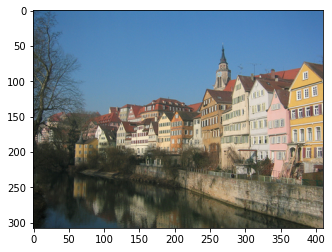

style image


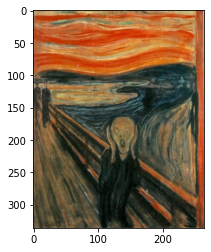

styled image using content_image as initial image


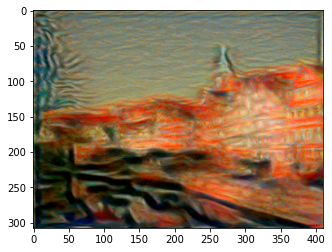

In [6]:
NST('pictures/content2.jpg','pictures/style2.jpg')

content image


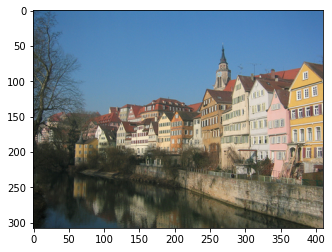

style image


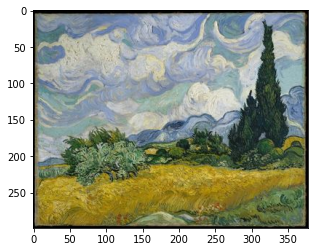

styled image using content_image as initial image


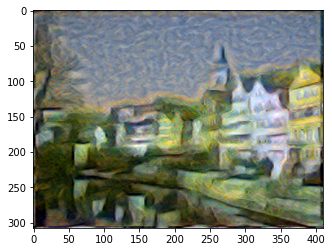

In [7]:
NST('pictures/content2.jpg','pictures/style3.jpg')